## HAR data using PCA

In [1]:
# 데이터 읽기

import pandas as pd
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/' + \
      'master/dataset/HAR_dataset/features.txt'

feature_name_df = pd.read_csv(url, sep='\s+', header = None, # txt 파일에 index, name이 1개 혹은 그 이상의 공백으로 나눠져 있어 sep 조건을 저렇게 거는 것
                              names=['column_index', 'column_name'])

feature_name = feature_name_df.iloc[:, 1].values.tolist()

feature_name_df.head()

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [2]:
# X data 불러오기

X_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/' + \
              'master/dataset/HAR_dataset/train/X_train.txt'
X_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/' + \
             'master/dataset/HAR_dataset/test/X_test.txt'

X_train = pd.read_csv(X_train_url, sep='\s+', header=None)
X_test = pd.read_csv(X_test_url, sep='\s+', header=None)

X_train.columns = feature_name
X_test.columns = feature_name

In [3]:
# y data 불러오기

y_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/' + \
              'master/dataset/HAR_dataset/train/y_train.txt'
y_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/' + \
             'master/dataset/HAR_dataset/test/y_test.txt'

y_train = pd.read_csv(y_train_url, sep='\s+', header=None, names=['action'])
y_test = pd.read_csv(y_test_url, sep='\s+', header=None, names=['action'])

In [4]:
# shape 확인

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

In [5]:
# 이전에 사용한 get_pca_data 함수 선언

from sklearn.decomposition import PCA

def get_pca_data(ss_data, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(ss_data)

    return pca.transform(ss_data), pca

In [6]:
# PCA fitting

HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pca.shape

(7352, 2)

In [7]:
pca.mean_.shape, pca.components_.shape

((561,), (2, 561))

In [8]:
# 이름 붙이기 위한 cols 생성

cols = ['pca_' + str(n) for n in range(pca.components_.shape[0])]
cols

['pca_0', 'pca_1']

In [9]:
# PCA 결과를 저장하는 함수

def get_pd_from_pca(pca_data, col_num):
    cols = ['pca_'+str(n) for n in range(col_num)]
    return pd.DataFrame(pca_data, columns=cols)

In [10]:
# 위에서 만든 HAR_pca 이용하여 dataframe 생성

HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train # X_train 값만 들어있으므로, 결과인 y_train 넣어줌
HAR_pd_pca.head()

,pca_0,pca_1,action
0,-5.520280,-0.290277,5
1,-5.535350,-0.082530,5
2,-5.474988,0.287387,5
3,-5.677232,0.897031,5
4,-5.748749,1.162952,5


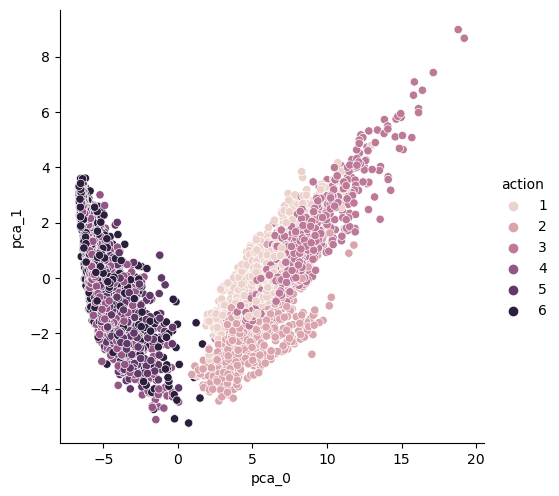

In [11]:
# pairplot 확인

import seaborn as sns

sns.pairplot(HAR_pd_pca, hue='action', height=5, x_vars=['pca_0'], y_vars=['pca_1']);

In [12]:
# PCA 특성 값 확인 함수 선언

import numpy as np

def print_pca_results(pca):
    print('PCA Explained Variance: ', pca.explained_variance_)
    print('PCA Explained Variance Ratio: ', pca.explained_variance_ratio_)
    print('Sum of PCA Explained Variance Ratio: ', np.sum(pca.explained_variance_ratio_))

In [13]:
print_pca_results(pca)

PCA Explained Variance:  [34.82363041  2.73504627]
PCA Explained Variance Ratio:  [0.6255444  0.04913023]
Sum of PCA Explained Variance Ratio:  0.6746746270487755


In [14]:
# component를 3개로 늘리면?

HAR_pca2, pca2 = get_pca_data(X_train, n_components=3)

print_pca_results(pca2)

PCA Explained Variance:  [34.82363041  2.73504627  2.29439284]
PCA Explained Variance Ratio:  [0.6255444  0.04913023 0.04121467]
Sum of PCA Explained Variance Ratio:  0.7158893015785947


In [15]:
# component를 10개로 늘리면?

HAR_pca3, pca3 = get_pca_data(X_train, n_components=10)

print_pca_results(pca3)

PCA Explained Variance:  [34.82363041  2.73504627  2.29439284  1.04377529  0.943517    0.70815229
  0.65505257  0.59509003  0.53964676  0.47765229]
PCA Explained Variance Ratio:  [0.6255444  0.04913023 0.04121467 0.01874956 0.0169486  0.01272069
 0.01176685 0.01068973 0.00969379 0.00858017]
Sum of PCA Explained Variance Ratio:  0.8050386995453258


### PCA + Random Forest

In [16]:
# 561개의 column을 10개로 종합하여 random forest 를 돌려보자

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth' : [6, 8, 10],
    'n_estimators' : [50, 100, 200],
    'min_samples_leaf' : [8, 12],
    'min_samples_split' : [8, 12]
}

rf_clf = RandomForestClassifier(random_state=13, n_jobs=4)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=4)
grid_cv.fit(HAR_pca3, y_train.values.reshape(-1, ))

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=4, random_state=13),
             n_jobs=4,
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [8, 12],
                         'min_samples_split': [8, 12],
                         'n_estimators': [50, 100, 200]})

In [17]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [18]:
target_col = ['rank_test_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth']
cv_results_df[target_col].sort_values('rank_test_score').head()

,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
29,1,0.838275,200,10
26,1,0.838275,200,10
17,3,0.837595,200,8
32,3,0.837595,200,10
14,3,0.837595,200,8


In [19]:
grid_cv.best_params_

{'max_depth': 10,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 200}

In [20]:
grid_cv.best_score_

0.8382752992383025

In [21]:
from sklearn.metrics import accuracy_score

rf_clf_best = grid_cv.best_estimator_
rf_clf_best.fit(HAR_pca3, y_train.values.reshape(-1,))

pred1 = rf_clf_best.predict(pca3.transform(X_test))

In [22]:
accuracy_score(y_test, pred1)

0.8564642008822532

### PCA + XGBoost

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_test['action'] = le.fit_transform(y_test['action'])
y_train['action'] = le.fit_transform(y_train['action'])
y_train.head()

,action
0,4
1,4
2,4
3,4
4,4


In [24]:
import time
from xgboost import XGBClassifier

evals = [(pca3.transform(X_test), y_test)]

start_time = time.time()

xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth = 3)
xgb.fit(HAR_pca3, y_train.values.reshape(-1,),
        early_stopping_rounds=10, eval_set=evals)
print('Fit time :', time.time()-start_time)

[0]	validation_0-mlogloss:1.61430
[1]	validation_0-mlogloss:1.47582
[2]	validation_0-mlogloss:1.35833
[3]	validation_0-mlogloss:1.26288
[4]	validation_0-mlogloss:1.18059
[5]	validation_0-mlogloss:1.11086
[6]	validation_0-mlogloss:1.04525
[7]	validation_0-mlogloss:0.98939
[8]	validation_0-mlogloss:0.94062
[9]	validation_0-mlogloss:0.89311
[10]	validation_0-mlogloss:0.85084
[11]	validation_0-mlogloss:0.81154
[12]	validation_0-mlogloss:0.78005
[13]	validation_0-mlogloss:0.75033
[14]	validation_0-mlogloss:0.72398


c:\Users\User\miniconda3\envs\ds_study\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-mlogloss:0.69894
[16]	validation_0-mlogloss:0.67549
[17]	validation_0-mlogloss:0.65526
[18]	validation_0-mlogloss:0.63711
[19]	validation_0-mlogloss:0.61860
[20]	validation_0-mlogloss:0.60403
[21]	validation_0-mlogloss:0.58709
[22]	validation_0-mlogloss:0.57347
[23]	validation_0-mlogloss:0.55911
[24]	validation_0-mlogloss:0.54749
[25]	validation_0-mlogloss:0.53696
[26]	validation_0-mlogloss:0.52604
[27]	validation_0-mlogloss:0.51651
[28]	validation_0-mlogloss:0.50655
[29]	validation_0-mlogloss:0.49862
[30]	validation_0-mlogloss:0.49036
[31]	validation_0-mlogloss:0.48185
[32]	validation_0-mlogloss:0.47473
[33]	validation_0-mlogloss:0.46847
[34]	validation_0-mlogloss:0.46225
[35]	validation_0-mlogloss:0.45629
[36]	validation_0-mlogloss:0.45067
[37]	validation_0-mlogloss:0.44426
[38]	validation_0-mlogloss:0.43835
[39]	validation_0-mlogloss:0.43372
[40]	validation_0-mlogloss:0.42883
[41]	validation_0-mlogloss:0.42443
[42]	validation_0-mlogloss:0.41955
[43]	validation_0-ml

In [25]:
accuracy_score(y_test, xgb.predict(pca3.transform(X_test)))

0.8646080760095012

## MNIST with PCA & kNN

* NIST dataset (National Institute of Standards and Technology)
  - 필기체 인식 데이터 셋 (우편 등의 문자 인식을 위해 사용됨) 

<br>

* MNIST (Modified~)
  - NIST 데이터 중 숫자만을 가져온 것
  - 28 * 28 pixels, 0~9 images & labels
  - 60000 training set, 10000 test set 
  
<br>

* 데이터셋 출처: Kaggle
  - https://www.kaggle.com/oddrationale/mnist-in-csv

In [26]:
# 데이터 읽기

import pandas as pd

df_train = pd.read_csv('../ML_data/mnist_train.csv')
df_test = pd.read_csv('../ML_data/mnist_test.csv')

df_train.shape, df_test.shape

((60000, 785), (10000, 785))

In [27]:
# 데이터 확인

df_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* label = 어떤 숫자인지 (ML에서 답에 해당)
* 각 픽셀이 검은색인지 흰색인지 표현한 것

In [28]:
# 데이터 정리

import numpy as np

X_train = np.array(df_train.iloc[:, 1:])
y_train = np.array(df_train['label'])

X_test = np.array(df_test.iloc[:, 1:])
y_test = np.array(df_test['label'])

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [29]:
# 데이터 임의 선정하여 출력시 어떠한 모양인지 확인

import random

samples = random.choices(population=range(0, 60000), k=16) # 6만 숫자 중에 16개 선택

samples

[46698,
 14379,
 50634,
 11159,
 56289,
 49816,
 38229,
 58259,
 18267,
 85,
 35788,
 19817,
 14410,
 4257,
 22553,
 14150]

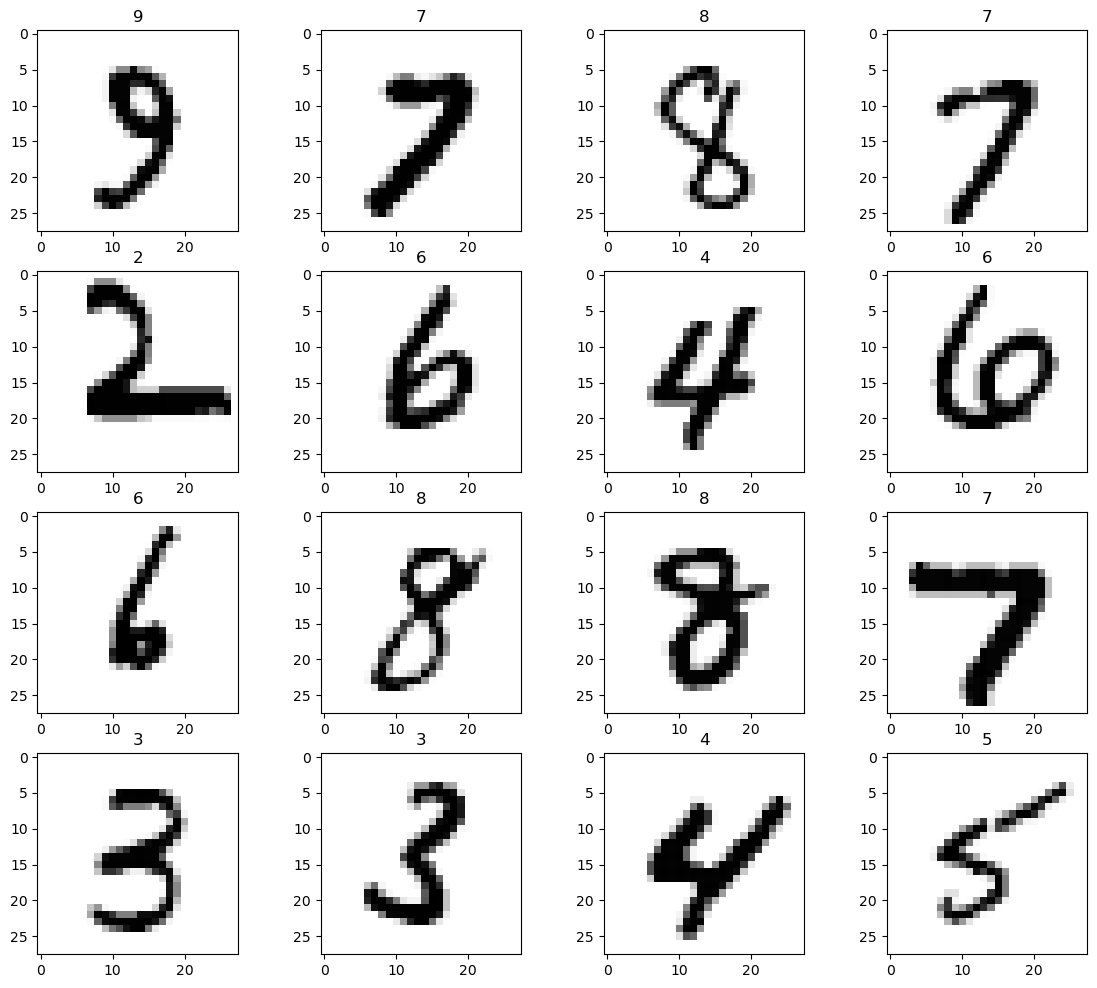

In [30]:
# 위에서 선정한 16개의 숫자로 훈련 데이터에서 추출하여 plot

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))

for idx, n in enumerate(samples):
    plt.subplot(4, 4, idx+1)
    plt.imshow(X_train[n].reshape(28, 28), cmap = 'Greys', interpolation='nearest')
    plt.title(y_train[n])

plt.show()

In [31]:
# kNN 적용

from sklearn.neighbors import KNeighborsClassifier
import time

start_time = time.time()

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
print('Fit time: ', time.time() - start_time)

Fit time:  0.10509514808654785


In [32]:
# kNN prediction

from sklearn.metrics import accuracy_score

start_time = time.time()
pred = clf.predict(X_test)

print('Fit time: ', time.time() - start_time)
print(accuracy_score(y_test, pred))

Fit time:  13.614362239837646
0.9688


In [33]:
# kNN은 각 원소마다 거리를 측정후에 선정한 neighbors 수에 따라 그룹화하는 것이므로
# 시간 소모를 줄이기 위해 PCA로 차원을 줄여주면 좋음

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe = Pipeline([
    ('pca', PCA()),
    ('clf', KNeighborsClassifier())
])

parameters = {
    'pca__n_components' : [2, 5, 10],
    'clf__n_neighbors' : [5, 10, 15]
}

kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=13)
grid = GridSearchCV(pipe, parameters, cv=kf, n_jobs=-1, verbose = 1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'clf__n_neighbors': [5, 10, 15],
                         'pca__n_components': [2, 5, 10]},
             verbose=1)

In [34]:
# best score, parameters 확인

print('Best score: %0.3f' % grid.best_score_)
print('Best parameters set: ')
best_parameters = grid.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' %(param_name, best_parameters[param_name]))


Best score: 0.931
Best parameters set: 
	clf__n_neighbors: 10
	pca__n_components: 10


In [35]:
# best estimator 적용하여 accuracy score 확인

pred = grid.best_estimator_.predict(X_test)

accuracy_score(y_test, pred)

0.929

* 원래 데이터 accuracy: 96.88%
* PCA 활용, 차원 축소 후 데이터 accuracy: 92.87%
* 그러나 시간은 1/10로 줄어듦
* 훨씬 더 방대한 데이터와 차원을 다루게 되면 PCA는 강력한 툴이 될 수 있음

In [36]:
# classification_report, confusion_matrix 확인

def results(y_pred, y_test):
    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    print('=================> Confusion Matrix <=================')
    print(confusion)
    print('======================================================')

results(grid.predict(X_train), y_train)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5923
           1       0.98      0.99      0.98      6742
           2       0.96      0.96      0.96      5958
           3       0.94      0.90      0.92      6131
           4       0.94      0.93      0.93      5842
           5       0.93      0.94      0.93      5421
           6       0.96      0.98      0.97      5918
           7       0.96      0.95      0.96      6265
           8       0.92      0.91      0.91      5851
           9       0.90      0.91      0.90      5949

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000

=================> Confusion Matrix <=================
[[5798    2   13   11    6   41   32    2   14    4]
 [   0 6670   24    9    6    3    7    6    8    9]
 [  44    8 5733   21   12   10   27   36   59    8]
 [  24   29   81 5524   12 

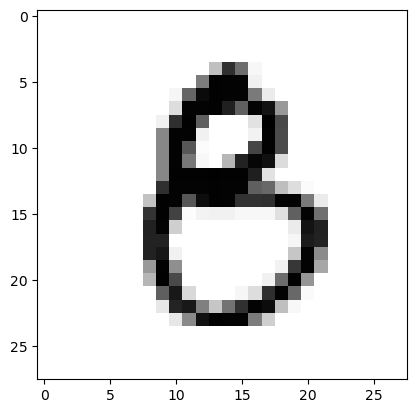

Answer is :  [5]
Real label is :  8


In [37]:
# 특정 element 숫자 다시 확인

n = 800
plt.imshow(X_test[n].reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

print('Answer is : ', grid.best_estimator_.predict(X_test[n].reshape(1, 784)))
print('Real label is : ', y_test[n])

In [38]:
# 틀린 데이터 관찰

preds = grid.best_estimator_.predict(X_test)
preds

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [39]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [40]:
# 틀린 데이터만 추출

wrong_results = X_test[y_test != preds]
wrong_results

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [41]:
# 틀린 데이터 개수 확인

wrong_results.shape[0]

710

In [42]:
# plot 할 데이터 16개 랜덤 추출

samples = random.choices(population=range(0, wrong_results.shape[0]), k=16)

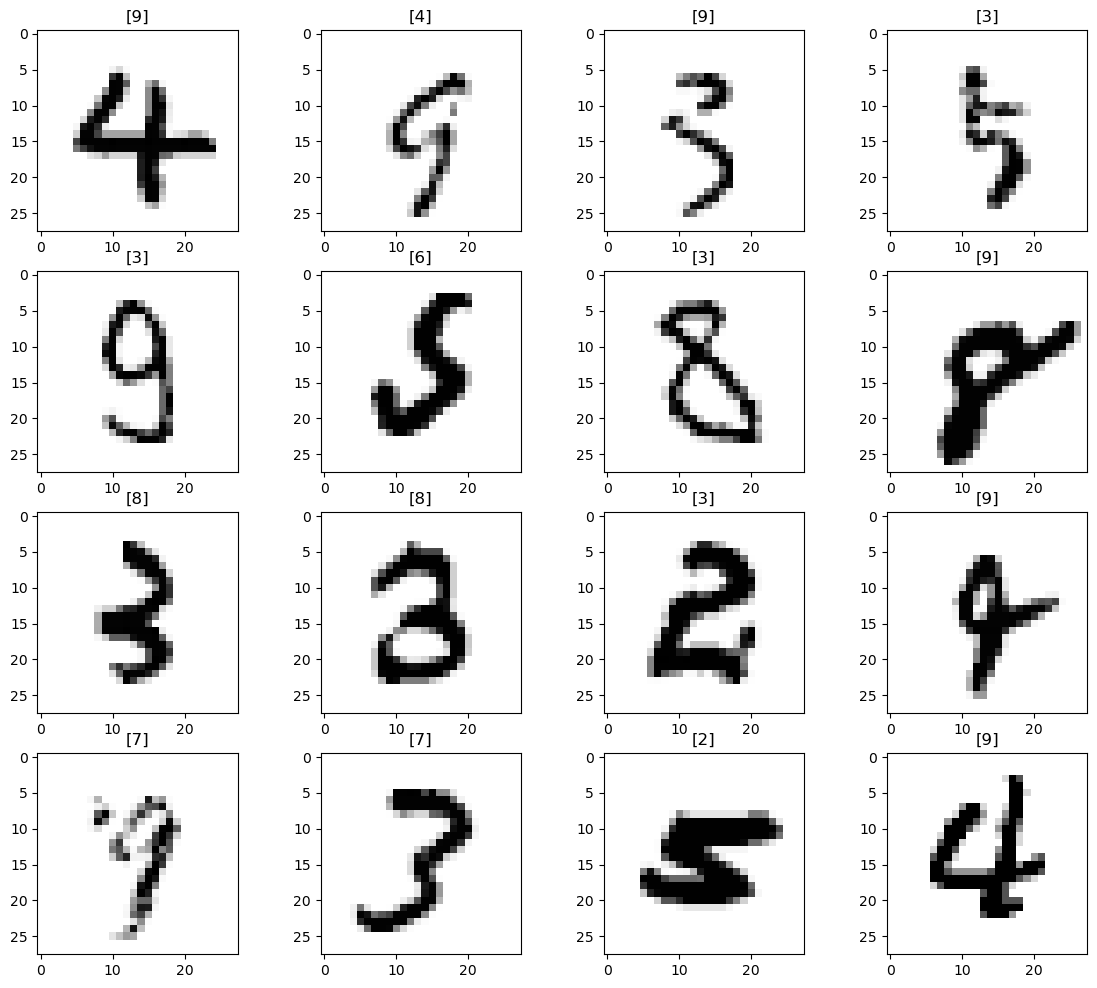

In [43]:
# 틀린 데이터 plot

plt.figure(figsize=(14, 12))

for idx, n in enumerate(samples):
    plt.subplot(4, 4, idx+1)
    plt.imshow(wrong_results[n].reshape(28, 28), cmap='Greys')
    pred_digit = grid.best_estimator_.predict(wrong_results[n].reshape(1, 784))
    plt.title(str(pred_digit))

plt.show()

## Titanic with PCA and kNN

In [44]:
# 데이터 읽기

import pandas as pd

titanic_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/titanic.xls'

titanic = pd.read_excel(titanic_url)
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [45]:
# 이름 분리하여 title 생성

import re

title = []

for idx, dataset in titanic.iterrows():
    title.append(re.search('\,\s\w+(\s\w+)?\.', dataset['name']).group()[2:-1])

titanic['title'] = title
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,title
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",Miss
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",Master
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Miss
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",Mr
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Mrs


In [46]:
# 귀족, 평민 등급 구별

titanic['title'] = titanic.title.replace('Mlle', 'Miss')
titanic['title'] = titanic.title.replace('Ms', 'Miss')
titanic['title'] = titanic.title.replace('Mme', 'Mrs')

Rare_f = ['Dona', 'Dr', 'Lady', 'the Countess']
Rare_m = ['Capt', 'Col', 'Don', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Master']

for each in Rare_f:
    titanic['title'] = titanic['title'].replace(each, 'Rare_f')

for each in Rare_m:
    titanic['title'] = titanic['title'].replace(each, 'Rare_m')

titanic['title'].unique()

array(['Miss', 'Rare_m', 'Mr', 'Mrs', 'Rare_f'], dtype=object)

In [47]:
# gender, grade 컬럼 생성

from sklearn.preprocessing import LabelEncoder

le_grade = LabelEncoder()
le_sex = LabelEncoder()
le_grade.fit(titanic['title'])
le_sex.fit(titanic['sex'])
titanic['grade'] = le_grade.transform(titanic['title'])
titanic['gender'] = le_sex.transform(titanic['sex'])

le_grade.classes_, le_sex.classes_

(array(['Miss', 'Mr', 'Mrs', 'Rare_f', 'Rare_m'], dtype=object),
 array(['female', 'male'], dtype=object))

In [48]:
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,title,grade,gender
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",Miss,0,0
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",Rare_m,4,1
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Miss,0,0
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",Mr,1,1
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Mrs,2,0


In [49]:
# null 데이터 제거

titanic = titanic[titanic['age'].notnull()]
titanic = titanic[titanic['fare'].notnull()]

titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1045 entries, 0 to 1308
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1045 non-null   int64  
 1   survived   1045 non-null   int64  
 2   name       1045 non-null   object 
 3   sex        1045 non-null   object 
 4   age        1045 non-null   float64
 5   sibsp      1045 non-null   int64  
 6   parch      1045 non-null   int64  
 7   ticket     1045 non-null   object 
 8   fare       1045 non-null   float64
 9   cabin      272 non-null    object 
 10  embarked   1043 non-null   object 
 11  boat       417 non-null    object 
 12  body       119 non-null    float64
 13  home.dest  685 non-null    object 
 14  title      1045 non-null   object 
 15  grade      1045 non-null   int32  
 16  gender     1045 non-null   int32  
dtypes: float64(3), int32(2), int64(4), object(8)
memory usage: 138.8+ KB


In [50]:
# 데이터 분리

from sklearn.model_selection import train_test_split

X = titanic[['pclass', 'age', 'sibsp', 'parch', 'fare', 'gender', 'grade']].astype('float')

y = titanic['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [51]:
# PCA 적용 준비

from sklearn.decomposition import PCA
import numpy as np

def get_pca_data(ss_data, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(ss_data)

    return pca.transform(ss_data), pca

def get_pd_from_pca(pca_data, col_num):
    cols = ['pca_'+str(n+1) for n in range(col_num)]
    return pd.DataFrame(pca_data, columns=cols)

def print_variance_ratio(pca, only_sum=False):
    if only_sum==False:
        print('variance_ratio: ', pca.explained_variance_ratio_)
    print('sum of variance_ratio: ', np.sum(pca.explained_variance_ratio_))

In [52]:
# 7개 컬럼을 2개로 축소하여 설명도 확인

pca_data, pca = get_pca_data(X_train, n_components=2)
print_variance_ratio(pca)

variance_ratio:  [0.93577394 0.06326916]
sum of variance_ratio:  0.999043100951126


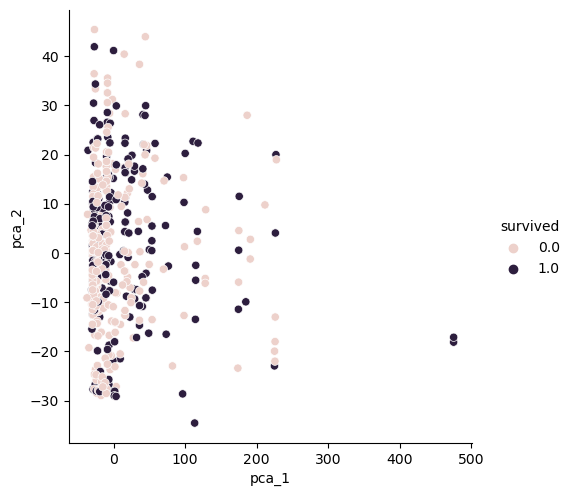

In [53]:
# plotting

import seaborn as sns

pca_columns = ['pca_1', 'pca_2']
pca_pd = get_pd_from_pca(pca_data, 2)
pca_pd['survived'] = y_train

sns.pairplot(pca_pd, hue='survived', height=5,
             x_vars=['pca_1'], y_vars = ['pca_2']);

In [54]:
# 구분이 쉽지 않아 n_components 3개로 만들고 확인

pca_data, pca = get_pca_data(X_train, n_components=3)
print_variance_ratio(pca)

variance_ratio:  [9.35773938e-01 6.32691630e-02 4.00903990e-04]
sum of variance_ratio:  0.9994440049413539


In [55]:
import plotly.express as px

pca_pd = get_pd_from_pca(pca_data, 3)
pca_pd['survived'] = y_train

fig = px.scatter_3d(pca_pd, 
                    x='pca_1', y='pca_2', z='pca_3',
                    color='survived', symbol='survived',
                    opacity=0.5)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [56]:
# Pipeline 구축

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

estimators = [('scaler', StandardScaler()),
              ('pca', PCA(n_components=3)),
              ('clf', KNeighborsClassifier(n_neighbors=20))]

pipe = Pipeline(estimators)
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
print(accuracy_score(y_test, pred))

0.7703349282296651


## 네이버 책 가격 회귀 분석

In [57]:
import urllib.request
import json
import datetime
import pandas as pd

client_id = "vFEuXx4wKKgRduUHv1LL"
client_secret = "XtWBnGKhto"

def gen_search_url(api_node, search_text, start_num, disp_num):
    base = 'https://openapi.naver.com/v1/search'
    node = '/' + api_node + '.json'
    param_query = '?query=' + urllib.parse.quote(search_text)
    param_start = '&start=' + str(start_num)
    param_disp = '&display=' + str(disp_num)

    return base + node + param_query + param_start + param_disp

def get_result_onpage(url):
    request = urllib.request.Request(url)
    request.add_header('X-Naver-Client-Id', client_id)
    request.add_header('X-Naver-Client-Secret', client_secret)

    response = urllib.request.urlopen(request)

    print('[%s] Url Request Success' % datetime.datetime.now())

    return json.loads(response.read().decode('utf-8'))

def delete_tag(input_str):
    input_str = input_str.replace('<b>', '')
    input_str = input_str.replace('</b>', '')

    return input_str

def get_fields(json_data):
    title = [delete_tag(each['title']) for each in json_data['items']]
    link = [each['link'] for each in json_data['items']]
    price = [each['discount'] for each in json_data['items']]
    publisher = [each['publisher'] for each in json_data['items']]
    isbn = [each['isbn'].split()[0] for each in json_data['items']]

    result_pd = pd.DataFrame({'title':title, 'price':price, 'isbn':isbn,
                              'link':link, 'publisher':publisher},
                              columns = ['title', 'price', 'publisher', 'isbn', 'link'])
    
    return result_pd


In [58]:
# 함수 테스트 1

url = gen_search_url('book', '파이썬', 10, 3)
test_result = get_result_onpage(url)

url, test_result

[2023-09-12 23:42:42.111891] Url Request Success


('https://openapi.naver.com/v1/search/book.json?query=%ED%8C%8C%EC%9D%B4%EC%8D%AC&start=10&display=3',
 {'lastBuildDate': 'Tue, 12 Sep 2023 23:42:42 +0900',
  'total': 921,
  'start': 10,
  'display': 3,
  'items': [{'title': '파이썬으로 쉽게 배우는 자료구조 (개정판)',
    'link': 'https://search.shopping.naver.com/book/catalog/40595743620',
    'image': 'https://shopping-phinf.pstatic.net/main_4059574/40595743620.20230711115354.jpg',
    'author': '최영규^천인국',
    'discount': '26100',
    'publisher': '생능출판',
    'pubdate': '20230626',
    'isbn': '9791192932187',
    'description': '자료구조(data structure)는 컴퓨터로 처리할 자료들을 효율적으로 관리하고 구조화시키기 위한 학문으로 컴퓨터 분야에서 매우 중요하고 기초적인 과목이다. 그러나 개념의 이해와 함께 코딩을 통한 구현 능력이 필수적으로 요구되기 때문에 학생들이 어려워하는 과목이기도 하다.\n이 책은 입문자들이 보다 쉽고 재미있게 자료구조를 공부하고 다양한 문제 해결에 활용할 수 있는 능력을 기르는데 초점을 맞추었다.'},
   {'title': '디딤돌 파이썬 (구조적 프로그래밍으로 설명한 파이썬 기초)',
    'link': 'https://search.shopping.naver.com/book/catalog/34233217628',
    'image': 'https://shopping-phinf.pstatic.net/main_3423321/34233217628

In [59]:
# 함수 테스트 2

test_pd = get_fields(test_result)
test_pd.head()

,title,price,publisher,isbn,link
0,파이썬으로 쉽게 배우는 자료구조 (개정판),26100,생능출판,9791192932187,https://search.shopping.naver.com/book/catalog...
1,디딤돌 파이썬 (구조적 프로그래밍으로 설명한 파이썬 기초),26100,인피니티북스,9791192373058,https://search.shopping.naver.com/book/catalog...
2,자기주도 파이썬 (정보영재 및 올림피아드를 위한 최적의 입문서),15300,복두출판사,9791166752025,https://search.shopping.naver.com/book/catalog...


In [60]:
# API를 이용하여 1000개 정보 수집

result_book = []

for n in range(1, 1000, 100):
    url = gen_search_url('book', '파이썬', n, 100)
    json_result = get_result_onpage(url)
    pd_result = get_fields(json_result)

    result_book.append(pd_result)

result_book = pd.concat(result_book)

[2023-09-12 23:42:42.429179] Url Request Success
[2023-09-12 23:42:42.754475] Url Request Success
[2023-09-12 23:42:43.045740] Url Request Success
[2023-09-12 23:42:43.346012] Url Request Success
[2023-09-12 23:42:43.653291] Url Request Success
[2023-09-12 23:42:43.946557] Url Request Success
[2023-09-12 23:42:44.250834] Url Request Success
[2023-09-12 23:42:44.560115] Url Request Success
[2023-09-12 23:42:44.907430] Url Request Success
[2023-09-12 23:42:45.056565] Url Request Success


In [61]:
# 데이터프레임 확인

result_book.head()

,title,price,publisher,isbn,link
0,파이썬과 데이터 과학 (파이썬으로 시작하는 데이터 과학과 기계학습),24700,생능출판,9788970504773,https://search.shopping.naver.com/book/catalog...
1,두근두근 파이썬 (만들면서 배우는),23750,생능출판,9788970506562,https://search.shopping.naver.com/book/catalog...
2,Do it! 점프 투 파이썬 (중학생도 첫날부터 실습하는 초고속 입문서),19010,이지스퍼블리싱,9791163034735,https://search.shopping.naver.com/book/catalog...
3,파이썬으로 만드는 인공지능,29450,한빛아카데미,9791156645085,https://search.shopping.naver.com/book/catalog...
4,파이썬 Express,28500,생능출판,9788970504667,https://search.shopping.naver.com/book/catalog...


In [62]:
# 인덱스 정리

result_book.reset_index(drop=True, inplace=True)
result_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      921 non-null    object
 1   price      921 non-null    object
 2   publisher  921 non-null    object
 3   isbn       921 non-null    object
 4   link       921 non-null    object
dtypes: object(5)
memory usage: 36.1+ KB


In [63]:
# 가격 float 형태로 변경

result_book.price = result_book.price.astype('float')
result_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      921 non-null    object 
 1   price      921 non-null    float64
 2   publisher  921 non-null    object 
 3   isbn       921 non-null    object 
 4   link       921 non-null    object 
dtypes: float64(1), object(4)
memory usage: 36.1+ KB


In [64]:
# 임의의 link에 대해 테스트 (책의 page 수 가져올 예정)

from bs4 import BeautifulSoup
from urllib.request import urlopen

url = result_book.link[0]
page = urlopen(url)
soup = BeautifulSoup(page, 'html.parser')
soup

<!DOCTYPE html>
<html lang="ko"><head><meta charset="utf-8"/><meta content="no-cache, no-store, must-revalidate" http-equiv="Cache-Control"/><meta content="width=device-width, initial-scale=1, shrink-to-fit=no, minimum-scale=1.0, maximum-scale=1.0, user-scalable=no" name="viewport"/><title>파이썬과 데이터 과학 : 네이버 도서</title><link href="https://ssl.pstatic.net/shoppingsearch/static/book-catalog/book-catalog-230907-104544/img/favicon.ico" rel="shortcut icon"/><link href="https://ssl.pstatic.net/shoppingsearch/static/book-catalog/book-catalog-230907-104544/img/favicon_180.png" rel="apple-touch-icon"/><meta content="파이썬과 데이터 과학 : 네이버 도서" property="og:title"/><meta content="네이버 도서 상세정보를 제공합니다." property="og:description"/><meta content="https://shopping-phinf.pstatic.net/main_3249151/32491517782.20230313182516.jpg" property="og:image"/><meta content="https://search.shopping.naver.com/book/catalog/32491517782" property="og:url"/><meta content="10" name="next-head-count"/><link href="https://static.n

In [65]:
soup.find_all(class_='bookBasicInfo_spec__qmQ_N')[0].get_text()[:-1]

'432'

In [66]:
# 페이지 정보 얻기

import numpy as np

def get_page_num(soup):
    try:
        page = soup.find_all(class_='bookBasicInfo_spec__qmQ_N')[0].get_text()
        return page[:-1]
    except:
        print('Error in get_page_num')
        return np.nan

get_page_num(soup)

'432'

In [67]:
# 만든 데이터 프레임에서 페이지 정보 얻기

import time

page_num_col = []

for url in result_book['link']:
    print(url)
    print(time.time())

    try:
        page_num = get_page_num(BeautifulSoup(urlopen(url), 'html.parser'))
        page_num_col.append(page_num)
    except:
        print('Error in urlopen')
        page_num_col.append(np.nan)
    print(len(page_num_col))
    time.sleep(0.5)

result_book['page_num'] = page_num_col

https://search.shopping.naver.com/book/catalog/32491517782
1694529765.9854093
1
https://search.shopping.naver.com/book/catalog/36813141618
1694529766.9382744
2
https://search.shopping.naver.com/book/catalog/40354085633
1694529767.929174
3
https://search.shopping.naver.com/book/catalog/32436237914
1694529768.873031
4
https://search.shopping.naver.com/book/catalog/32466599747
1694529769.7368157
5
https://search.shopping.naver.com/book/catalog/32507605957
1694529770.7277153
6
https://search.shopping.naver.com/book/catalog/36925491630
1694529771.8467312
7
https://search.shopping.naver.com/book/catalog/32458141395
1694529772.7575588
8
https://search.shopping.naver.com/book/catalog/38404352624
1694529773.7024164
9
https://search.shopping.naver.com/book/catalog/40595743620
1694529774.7093313
10
https://search.shopping.naver.com/book/catalog/34233217628
1694529775.58913
11
https://search.shopping.naver.com/book/catalog/36019497623
1694529776.4368994
12
https://search.shopping.naver.com/book/ca

In [68]:
len(page_num_col)

921

In [70]:
# page number float 형으로 변경
result_book.page_num = result_book.page_num.astype('float')
result_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      921 non-null    object 
 1   price      921 non-null    float64
 2   publisher  921 non-null    object 
 3   isbn       921 non-null    object 
 4   link       921 non-null    object 
 5   page_num   914 non-null    float64
dtypes: float64(2), object(4)
memory usage: 43.3+ KB


In [71]:
# 놓친 데이터 다시 획득 가능한지 시도

for idx, row in result_book.iterrows():
    if np.isnan(row['page_num']):
        print('Start fix')
        print(row['link'])
        page_num = get_page_num(BeautifulSoup(urlopen(row['link']), 'html.parser'))
        result_book.loc[idx, 'page_num'] = page_num
        time.sleep(0.5)

Start fix
https://search.shopping.naver.com/book/catalog/32492583618
Error in get_page_num
Start fix
https://search.shopping.naver.com/book/catalog/32444932070
Error in get_page_num
Start fix
https://search.shopping.naver.com/book/catalog/42346984619
Error in get_page_num
Start fix
https://search.shopping.naver.com/book/catalog/32497231009
Error in get_page_num
Start fix
https://search.shopping.naver.com/book/catalog/32506228826
Error in get_page_num
Start fix
https://search.shopping.naver.com/book/catalog/32496154642
Error in get_page_num
Start fix
https://search.shopping.naver.com/book/catalog/32438227707
Error in get_page_num


* 책마다 정보가 다르고, 강의 내용과 html 이 좀 달라져서, 해당 링크에 들어가서 직접 tag, id 등을 확인해야함

In [72]:
# 엑셀로 정리

writer = pd.ExcelWriter('./python_books.xlsx', engine='xlsxwriter')
result_book.to_excel(writer, sheet_name = 'Sheet1')

workbook = writer.book
worksheet = writer.sheets['Sheet1']
worksheet.set_column('A:A', 5) # 컬럼 너비 지정
worksheet.set_column('B:B', 60)
worksheet.set_column('C:C', 10)
worksheet.set_column('D:D', 15)
worksheet.set_column('E:E', 10)
worksheet.set_column('F:F', 50)

writer.save()

C:\Users\User\AppData\Local\Temp\ipykernel_13200\310095981.py:15: FutureWarning:

save is not part of the public API, usage can give unexpected results and will be removed in a future version



### 책 가격 회귀 분석

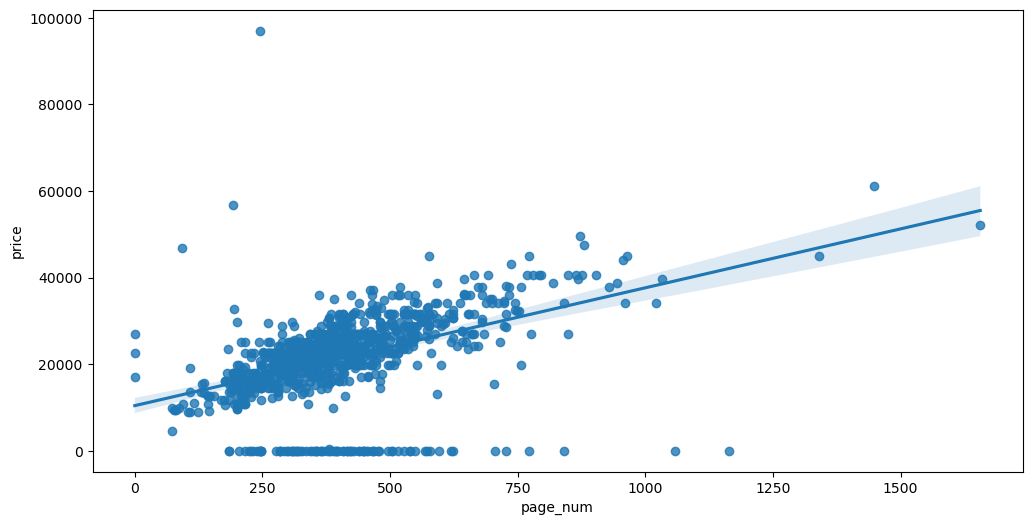

In [73]:
# seaborn 이용하여 책 페이지 수와 가격 간의 관계 확인

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.regplot(x='page_num', y='price', data=result_book)
plt.show()

In [74]:
# 80000원이 넘어가는 책 정보 확인

result_book[result_book['price'] > 80000]

,title,price,publisher,isbn,link,page_num
559,"한권으로 파이썬과 드론 날로먹기: 인공지능편 (파이썬의 기초문법, 응용 예제가 한권에)",97020.0,잇플,9791191198188,https://search.shopping.naver.com/book/catalog...,245.0


In [75]:
# 출판사 별 책 권수 확인 >> 전체 책을 조회한 것이 아니기 때문에 절대적인 기준이 될 수 없음을 인지할 것

result_book['publisher'].value_counts()

에이콘출판       106
한빛미디어        84
위키북스         60
길벗           44
비제이퍼블릭       44
           ... 
인디라이프         1
지란지교에듀랩       1
경북대학교출판부      1
시대고시기획        1
이한미디어         1
Name: publisher, Length: 169, dtype: int64

In [76]:
# 출판사 자체 갯수 확인

len(result_book['publisher'].unique())


169

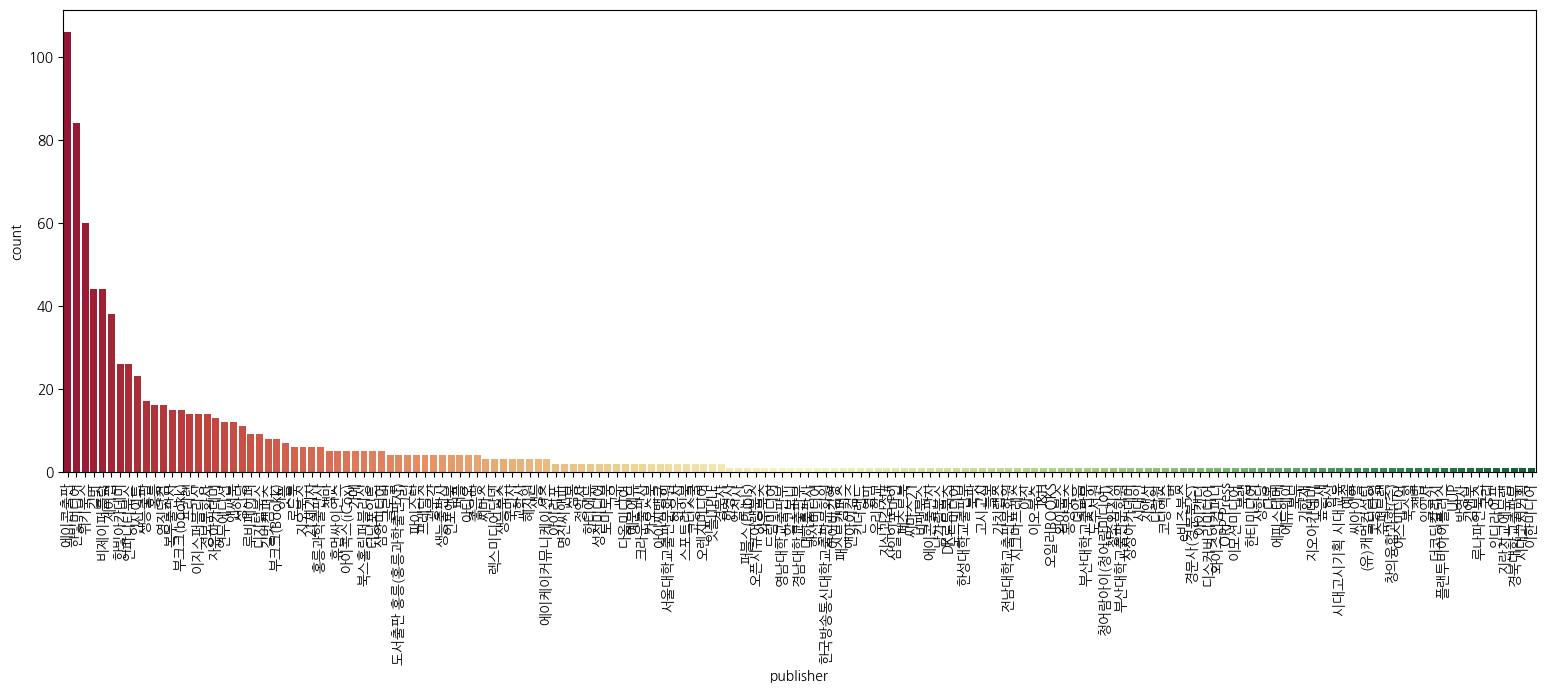

In [80]:
# countplot을 이용하여 출판사별 책 권수 확인

import koreanize_matplotlib

plt.figure(figsize=(19, 6))
sns.countplot(x ='publisher', data=result_book, palette='RdYlGn', # x 지정해주지 않으면 data가 무엇인지 countplot 함수가 인지 못함
              order=result_book['publisher'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

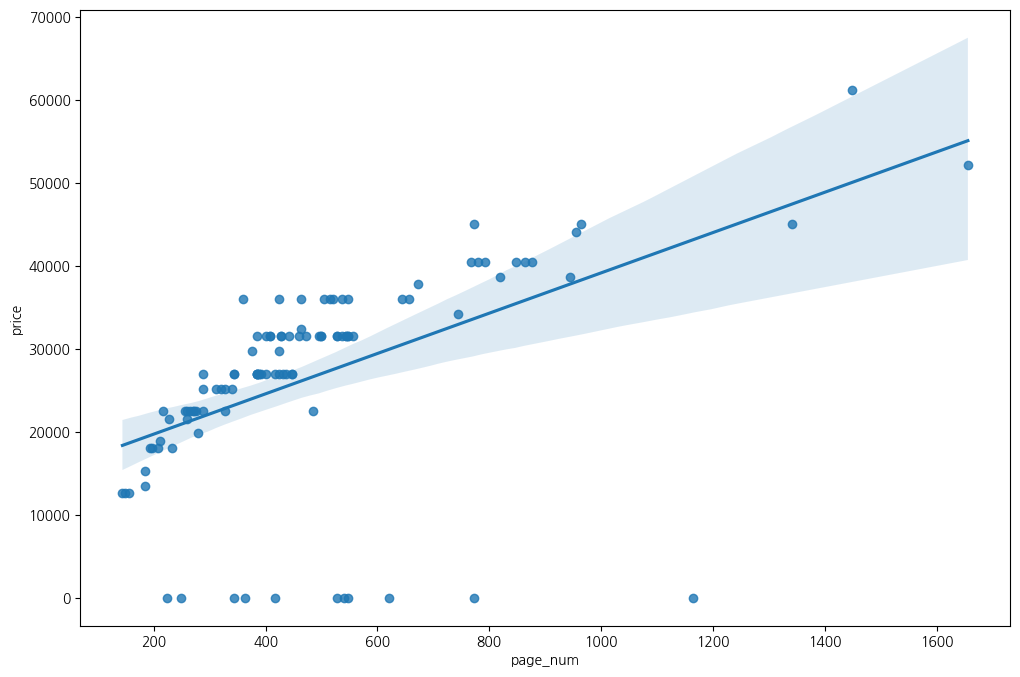

In [81]:
# 가장 책 권수가 많은 에이콘출판사만 이용

raw_1 = result_book[result_book['publisher']=='에이콘출판']

plt.figure(figsize=(12, 8))
sns.regplot(x='page_num', y='price', data=raw_1)
plt.show()

In [82]:
# 0원으로 조회되는 책들 확인

result_book[result_book['price'] < 10000]

,title,price,publisher,isbn,link,page_num
29,파이썬,0.0,생능출판,9788970508504,https://search.shopping.naver.com/book/catalog...,728.0
56,그림으로 정리한 알고리즘과 자료구조 (자바 + 파이썬),0.0,정보문화사,9788956747880,https://search.shopping.naver.com/book/catalog...,184.0
59,파이썬 연습,0.0,그린,9788957273012,https://search.shopping.naver.com/book/catalog...,446.0
91,똑똑한 파이썬 (주니어를 위한 최선의 코딩 학습),0.0,코딩스쿨,9791196440916,https://search.shopping.naver.com/book/catalog...,240.0
92,스타트 파이썬 (코딩 초보를 위한 최상의 파이썬 학습서!),0.0,코딩스쿨,9791196440909,https://search.shopping.naver.com/book/catalog...,578.0
...,...,...,...,...,...,...
892,PySpark 배우기 (파이썬과 스파크 2.0으로 대용량 데이터 처리 애플리케이션 ...,0.0,에이콘출판사,9791161750705,https://search.shopping.naver.com/book/catalog...,336.0
902,케라스 창시자에게 배우는 딥러닝 Deep Learning with Python (파...,0.0,길벗,9791160505979,https://search.shopping.naver.com/book/catalog...,476.0
906,Let’s Start Coding with Raptor & Python (랩터 & ...,0.0,앤아이컴즈,9788993163568,https://search.shopping.naver.com/book/catalog...,446.0
909,Let’s Start Coding with Raptor & Python(랩터 & 파...,0.0,이한미디어,9788993163506,https://search.shopping.naver.com/book/catalog...,423.0


In [83]:
# plotly box를 통해 확인

import plotly.express as px

px.box(result_book, y='price')

### 회귀 모델 구성

In [101]:
# Nan값과 0으로 인해 데이터 오차가 커지니 해당 데이터들 제거

raw_data = result_book.copy()

idx1 = raw_data[raw_data['price'] == 0].index
raw_data.drop(idx1, inplace=True)

idx2 = raw_data[raw_data['page_num'].isna()].index
raw_data.drop(idx2, inplace=True)

In [102]:
raw_data[raw_data['page_num'].isna()]

,title,price,publisher,isbn,link,page_num


In [103]:
raw_data[raw_data['price']==0]

,title,price,publisher,isbn,link,page_num


In [104]:
# 데이터 나누기

from sklearn.model_selection import train_test_split

X = raw_data['page_num'].values
y = raw_data['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

In [105]:
# 모델 학습

from sklearn.linear_model import LinearRegression

reg = LinearRegression()

reg.fit(X_train, y_train)

LinearRegression()

In [106]:
# 에러 계산

from sklearn.metrics import mean_squared_error

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))

print("RMSE of Train Data: ", rmse_tr)
print("RMSE of Test Data: ", rmse_test)

RMSE of Train Data:  5605.3656972585695
RMSE of Test Data:  5489.904037309781


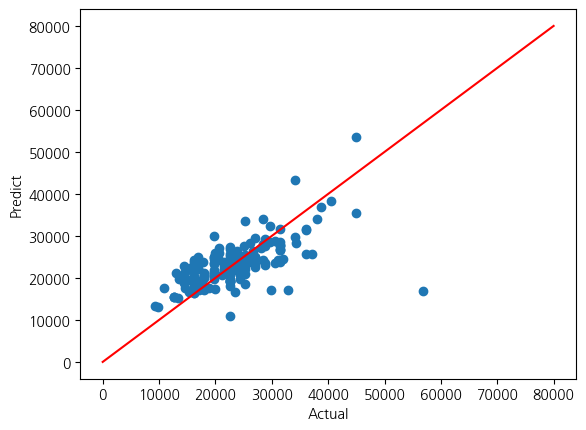

In [110]:
# 참값과 예측값 확인

plt.scatter(y_test, pred_test)
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.plot([0, 80000], [0, 80000], 'r') # 기준선 생성
plt.show()

* 위의 그래프는 전체 데이터를 대상으로 만들어진 것임
* 책의 분야별, 출판사별로 나누어서 테스트 해보는 것도 좋은 연습이 될 수 있음
* 특정 출판사 혹은 분야별로 많은 데이터를 축적한 다음에 해당 출판사/분야에서 책의 가격을 매김에 있어 어떠한 기준이 적용 되는지 등을 알아볼 수 있겠음